In [1]:
from __future__ import annotations
from typing_extensions import Callable
import os

import cv2
import OpenEXR
import mediapy
import numpy as np
import numpy.typing as npt

from helpers import *

# Generate and sum binary frames

### Data loading

First, let's download a high dynamic range image from which we will simulate binary frames. You can download this from our [release page](https://github.com/cpsiff/SPAD-ICCP-Summer-School/releases/tag/data) or equivalently if you're using linux/macOS you can uncomment and run the following:

In [2]:
# !wget https://github.com/cpsiff/SPAD-ICCP-Summer-School/releases/download/data/hdr_stairs_small.exr

In [3]:
# Load EXR from which we simulate binary frames
pcube = EmulatePhotonCube("hdr_stairs_small.exr")
bright_crop = np.s_[750:1250, 350:750]
dark_crop = np.s_[1700:2400, 1250:1750]

# Note: Once you've completed this activity you can try using a higher resolution image like so:
# !wget https://github.com/cpsiff/SPAD-ICCP-Summer-School/releases/download/data/hdr_stairs_large.exr
# pcube = EmulatePhotonCube("hdr_stairs_large.exr")
# bright_crop = np.s_[1500:2500, 700:1500]
# dark_crop = np.s_[3400:4800, 2500:3500]

### Visualization Helpers

In [4]:
def convert_to_uint8(im: npt.NDArray, quantile: float = 0.01) -> npt.NDArray:
    """Convert a floating point image to a uint8 by rescaling it.

    Args:
        im (npt.NDArray): Input floating point image.
        quantile (float, optional): Rescales the image using this quantile, everything below
            it will vbe mapped to 0 and above 1-quantile will become 255. Defaults to 0.01.

    Returns:
        npt.NDArray: Rescaled uint8 image.
    """
    vmin = np.quantile(im.flatten(), quantile)
    vmax = np.quantile(im.flatten(), 1 - quantile)
    vrange = (vmax - vmin) if vmin != vmax else 1.0
    im = (im - vmin) / vrange

    return np.clip(im * 255, 0, 255).astype(np.uint8)


def display_image(
    im: npt.NDArray,
    height: int = 600,
    quantile: float = 0.01,
    tonemap_fn: Callable | None = None,
):
    """Use mediapy to display an image and two default crops.

    Args:
        im (npt.NDArray): Floating point image to display.
        height (int, optional): Height of displayed images in pixels. Defaults to 600.
        quantile (float, optional): Same as in `convert_to_uint8`. Defaults to 0.01.
        tonemap_fn (Callable | None, optional): If supplied this function will be applied to
            the image and it's crops independently before displaying them. Defaults to None.
    """
    tonemap_fn = (lambda x: x) if tonemap_fn is None else tonemap_fn
    annotated = convert_to_uint8(tonemap_fn(im), quantile=quantile)

    # Draw bounding boxes for the two ROIs
    draw_rect_from_crop(annotated, bright_crop, color=(0, 0, 255))
    draw_rect_from_crop(annotated, dark_crop, color=(255, 0, 0))

    # Display the binary frame and the two crops
    mediapy.show_images(
        [
            annotated,
            convert_to_uint8(tonemap_fn(im[bright_crop]), quantile=quantile),
            convert_to_uint8(tonemap_fn(im[dark_crop]), quantile=quantile),
        ],
        height=height,
    )

### A single binary frame

,,

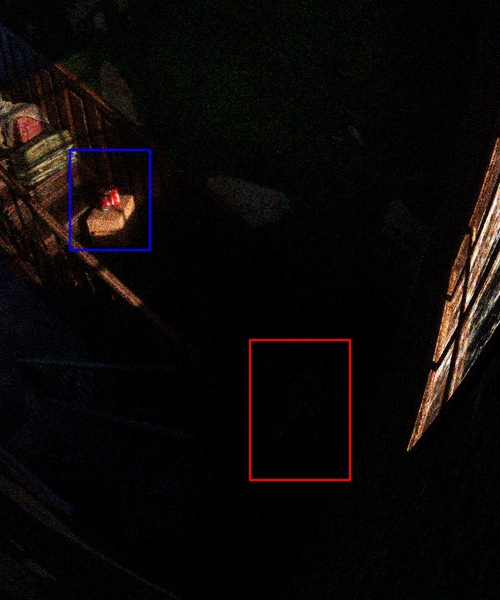
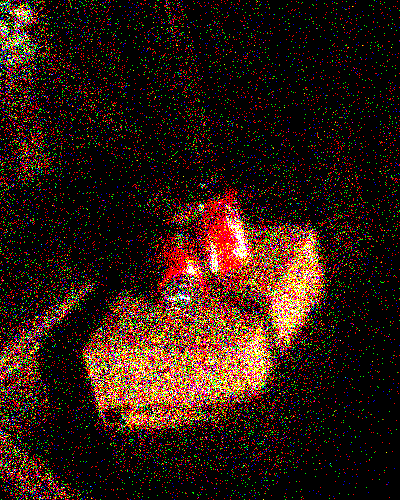
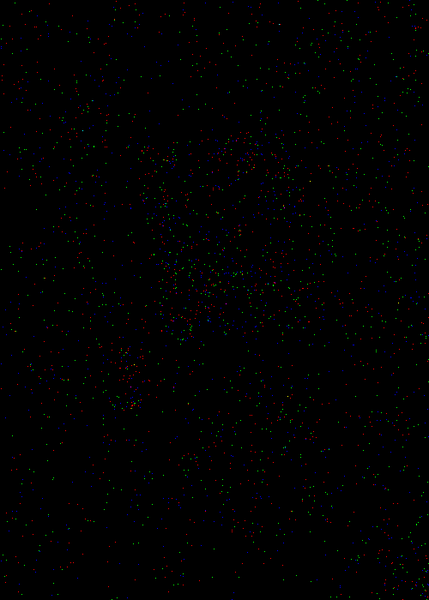

In [5]:
# Get a single binary frame at index 0 and display it
binary_frame = pcube[0]
display_image(binary_frame)

### The sum of binary frames

Let's now sum binary frames. What does the sum of 5 binary frames look like? How about the sum of 10 bitplanes? 

In [6]:
# Sum and display binary frames, limit yourself to small sums (less than 100 frames) for now.
# < -- Your code here -- >

**Question:** How does the reconstruction differ from the single binary frame shown above?  

**Answer:** _______

# Recovering the scene flux (linear intensity image)

So far you've summed binary frames, which is almost like having a longer (virtual) exposure. Longer exposures allow more light to be captured, and more details -- particularly in the dark regions -- to be revealed.  

However, because single photon cameras (SPCs) are binary devices, the sum of binary frames is different than counting the number of photons incident on the sensor. If many photons hit a pixel at once, it will still only output a `1`. Thus, we need to invert the SPAD response function to estimate the scene's flux. 

Recall, for a scene with flux $\phi$, the number of incident photons $k$ (during _some_ exposure time) on a pixel follows a Poisson distribution given by:

$$
P(k) = \frac{(\phi)^ke^{-\phi}}{k!} \,.
$$

which gets truncated due to the SPADs binary nature: 

$$
\begin{align}
P(B=0) &= P(k=0) = e^{-\phi},\\
P(B=1) &= P(k \ge 1) = 1-e^{-\phi}.
\end{align}
$$

How can we recover a good estimate of $\phi$ given many binary observations $B_i$? 

In [7]:
# Invert the SPAD response function above and estimate the scene flux using 10 binary frames. Display result.
# Note: You might want to `clip` values to [epsilon, 1.0] with some small epsilon (eg. 1e-6) to help with numerical stability!
# < -- Your code here -- >

**Question:** Notice the reconstruction seems darker than when simply summing binary frames, why is this? 

Hint: How is the image displayed?

**Answer:** _______

# Tonemapping

Now that we have a linear intensity image, we can tonemap it using existing techniques! Below is a common tonemapping method, try using it on your linear intensity frame!

In [8]:
def apply_gamma(
    im: npt.NDArray, gamma: float = 2.2, auto_scale: bool = False
) -> npt.NDArray:
    """Tonemap the image using a given gamma value.

    Args:
        im (npt.NDArray): Image to be tonemapped, expects a floating point image.
        gamma (float, optional): Gamma factor to use. Defaults to 2.2.
        auto_scale (bool, optional): If true, scale input image to have a mean
            value of ~0.5 before applying gamma. Defaults to False.

    Returns:
        npt.NDArray: Tonemapped image
    """
    if auto_scale:
        # Use the median of non-zero pixels to find a robust scaling target
        median_val = np.median(im[im > 0])
        scaling_factor = 0.5 / median_val if median_val > 0 else 1.0

        # Apply linear exposure scaling
        scaled_im = im * scaling_factor
    else:
        scaled_im = im

    # Apply gamma correction for display and convert to uint8
    gamma_corrected = np.clip(scaled_im ** (1 / 2.2), 0, 1)
    return gamma_corrected

In [9]:
# Try using the Gamma tonemap above to display your linear intensity image!
# Hint: Look at the signature of `display_image`.

# < -- Your code here -- >

The image is still very noisy, try using it with a linear intensity frame that is created with more than 10 binary frames.

In [10]:
# Create a linear intensity image with many more binary frames and try tonemapping it. How many frames are needed for the image to look good? Can you read the magazine cover?
# Hint: Summing binary frames can be slow, you can use pcube.sum_frames(start, stop) which will be mush faster.

# < -- Your code here -- >

Here's a more advanced tonemapping function provided by opencv. While common, it does not work well if the image is too noisy, either yielding dark frames or crashing entirely. 

In [11]:
def apply_drago(im: npt.NDArray, gamma: float = 1.0) -> npt.NDArray:
    """Apply Drago tonemapping algorithm to image.
    For more, see: https://resources.mpi-inf.mpg.de/tmo/logmap/logmap.pdf)

    Args:
        im (npt.NDArray): Image to be tonemapped, expects a floating point image.
        gamma (float, optional): optionally apply gamma correction
            first. Defaults to 1.0 (no correction).

    Returns:
        npt.NDArray: Tonemapped image
    """
    if np.logical_not(np.isfinite(im)).any():
        raise ValueError("Invalid image, detected NAN/INF value(s)!")
    tonemap = cv2.createTonemapDrago(gamma=gamma)
    ldr_tonemapped = tonemap.process(im.astype(np.float32))
    return ldr_tonemapped

In [12]:
# Try using the Drago tonemap above to display a linear intensity image. How many binary frames are needed?
# Hint: Summing binary frames can be slow, you can use pcube.sum_frames(start, stop) which will be much faster.

# < -- Your code here -- >

**Question:** Approximately how many binary frames need to be combined for the Drago tonemapping algorithm to give satisfactory results?

**Answer:** ______